In [38]:
# Exploratory data analysis on MyAniList, assessing top 100 anime
from urllib.request import urlopen as uReq
import urllib.parse
import random
from bs4 import BeautifulSoup as soup
import csv
%pip install seaborn
import numpy as npy
import pandas as pds
import seaborn as sea
import matplotlib.pyplot as plt
%matplotlib inline
from time import sleep
import datetime

# PART 1: Scraping data

# opening up connection, grabbing page
url = 'https://myanimelist.net/topanime.php?limit=0'
# set up your list to be used to write to a file.
rows = [['Rank', 'Title', 'Score', 'Your Score', 'Num Episodes', 'Air dates', 'Num Members', 'Genres', 'Status', 'Studios', 'Rating', 'Source']]
#get top 100 anime from myAniList
numList = [0, 50]
new_URL_list = []

for page in numList:
    uClient = uReq(url + str(page))
    page_html = uClient.read()
    uClient.close()
    # html parsing
    page_soup = soup(page_html, "html.parser")
    table = page_soup.find('table', attrs={'class': 'top-ranking-table'})
    results = table.find_all('tr')

    # you want to loop through all of the results
    for result in results:
        title = ''
        # td because your categories are under 'td' class
        data = result.find_all('td')
        # gives you the td class info for rank, and gives you the rank
        rank = data[0].getText().strip()

        # obtain your title that's contained within the h3 class.
        title_container = result.findAll("h3", {"class": "hoverinfo_trigger fl-l fs14 fw-b anime_ranking_h3"})
        # ensures that you don't look at your header, which would effectively be a NoneType for this situation
        if title_container:
            title = title_container[0].getText()
        else:
            continue

        # gives you the td class info for score, and gives you the score
        score = data[2].getText().strip()
        your_score = data[3].getText().strip()

        # Extra information about the anime
        info_HTML = result.findAll("div", {"class": "information di-ib mt4"})
        info = info_HTML[0].getText().strip()
        # separate info into 3 elements that go into a list
        info_list = info.splitlines()
        # cleaning up information
        for i in range(len(info_list)):
            info_list[i] = info_list[i].strip()
            i += 1

        num_episodes = info_list[0]
        air_date = info_list[1]
        num_members = info_list[2]

        # getting more information and handling broken URLs
        # For next 6 lines of code got help from StackOverflow because 
        # couldn't parse through some URLs. 
        # https://stackoverflow.com/questions/21628852/changing-hostname-in-a-url
        # Comment author: Omid Raha. Author Page: https://stackoverflow.com/users/538284/omid-raha 
        new_url = result.a['href']
        new_url = urllib.parse.urlsplit(new_url)
        new_url = list(new_url)
        new_url[2] = urllib.parse.quote(new_url[2])
        new_url = urllib.parse.urlunsplit(new_url)
        new_URL_list.append(new_url)

        # dealing with a forbidden error bug:
        # Used official python documentation for help with following
        # 5 lines of code: https://docs.python.org/3/library/urllib.request.html
        headers = {'User-Agent': 'Mozilla/5.0'}
        request = urllib.request.Request(new_url, None, headers)
        response = urllib.request.urlopen(request)
        Page_html = response.read()
        response.close()

        # html parsing
        Page_soup = soup(Page_html, "html.parser")
        extra_info = Page_soup.find('td', attrs={'class': 'borderClass'})
        # genres
        genres_html = extra_info.findAll('span', attrs={'itemprop': 'genre'})
        genres_list = []

        for i in range(len(genres_html)):
            genre = genres_html[i].getText()
            genres_list.append(genre)
        genres_string = ",".join(genres_list)

        # status
        status = extra_info.select_one('span:-soup-contains("Status:")').find_next_sibling(text=True).strip()
        # Studios
        if (extra_info.select_one('span:-soup-contains("Studios:")').find_next_sibling().get('title') != None):
            studios = extra_info.select_one('span:-soup-contains("Studios:")').find_next_sibling().get('title')
        else: 
            studios = None
        # Rating
        rating = extra_info.select_one('span:-soup-contains("Rating:")').find_next_sibling(text=True).strip()
        # source
        source = extra_info.select_one('span:-soup-contains("Source:")').find_next_sibling(text=True).strip()

        sleep(random.randint(0,3))

        # Writing to a CSV file
        rows.append([rank, title, score, your_score, num_episodes, air_date, num_members, genres_string, status, studios, rating, source])

        with open('topAnime.csv', 'w', encoding="utf-8", newline='') as f_output:
            csv_output = csv.writer(f_output)
            csv_output.writerows(rows)


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [39]:
# Part 2: Data Cleaning

data = pds.read_csv("topAnime.csv")
# rename columns
df = pds.DataFrame(data)
df.columns = ['rank', 'title', 'score', 'your_score', 'num_episodes', 'air_dates', 'num_members', 'genres', 'status', 'studios', 'rating', 'source']

In [40]:
#dropping your_score column
df.drop('your_score', axis = 1, inplace = True)
df.columns


Index(['rank', 'title', 'score', 'num_episodes', 'air_dates', 'num_members',
       'genres', 'status', 'studios', 'rating', 'source'],
      dtype='object')

In [41]:
#split Num episodes column to separate type and number
newList = df["num_episodes"].str.split(" ", n = 1, expand = True)
for i in range(len(newList[1])):
    newList[1][i] = newList[1][i].strip('()')
df["content_type"] = newList[0]
df["episode_count"] = newList[1]
df["episode_count"].replace('\D+', '', regex = True, inplace = True)
df.drop(columns=["num_episodes"], inplace = True)

In [42]:
# split genres column entries into a list of strings
df["genres"].str.split(pat = None, n = -1, expand = False)

0     [Action,Adventure,Comedy,Drama,Fantasy,Militar...
1     [Action,Comedy,Sci-Fi,Historical,Parody,Samura...
2     [Action,Drama,Fantasy,Mystery,Military,Super, ...
3                 [Drama,Sci-Fi,Suspense,Psychological]
4     [Comedy,Drama,Romance,Slice, of, Life,Supernat...
                            ...                        
95                 [Action,Drama,Sci-Fi,Mecha,Military]
96    [Action,Comedy,Sci-Fi,Historical,Parody,Samura...
97    [Action,Mystery,Sci-Fi,Mecha,Military,Police,S...
98                       [Action,Comedy,School,Shounen]
99    [Action,Comedy,Sci-Fi,Historical,Parody,Samura...
Name: genres, Length: 100, dtype: object

In [43]:
action_count = df['genres'].str.count("Action").sum()
drama_count = df['genres'].str.count("Drama").sum()
sof_count = df['genres'].str.count("Slice of Life").sum()
comedy_count = df['genres'].str.count("Comedy").sum()
adventure_count = df['genres'].str.count("Adventure").sum()
sci_fi_count = df['genres'].str.count("Sci-Fi").sum()
psychological_count = df['genres'].str.count("Psychological").sum()
horror_count = df['genres'].str.count("Horror").sum()

In [44]:
count_dict = {'Action': action_count, 'Drama': drama_count, 'Slice of Life': sof_count, 'Comedy': comedy_count, 'Adventure': adventure_count, 'Sci-Fi': sci_fi_count, 'Psychological': psychological_count, 'Horror': horror_count}

In [45]:
print(count_dict)

{'Action': 44, 'Drama': 55, 'Slice of Life': 22, 'Comedy': 36, 'Adventure': 20, 'Sci-Fi': 26, 'Psychological': 9, 'Horror': 2}


In [46]:
#cleaning up num_members column
df["num_members"].replace('\D+', '', regex = True, inplace = True)

In [47]:
df.isnull().sum()
# addressing null/empty values

rank             0
title            0
score            0
air_dates        0
num_members      0
genres           0
status           0
studios          0
rating           0
source           0
content_type     0
episode_count    0
dtype: int64

In [48]:
# modifying dates

# split air_dates column into start and end date
dateList = df["air_dates"].str.split("-", n = 1, expand = True)
df['air_start_date'] = dateList[0]
df['air_end_date'] = dateList[1]
df.drop(columns = ['air_dates'], inplace = True)
df.drop(columns = ['rank'], inplace = True)

# changing dates to numerical notation
df['air_start_date'] = pds.to_datetime(df['air_start_date'])
df['air_start_date'] = df['air_start_date'].dt.date.apply(lambda x: x.strftime('%m-%Y') if pds.notnull(x) else npy.NaN)

df['air_end_date'] = pds.Series(df['air_end_date'])
df['air_end_date'] = pds.to_datetime(df['air_end_date'], errors = 'coerce')
df['air_end_date'] = df['air_end_date'].dt.date.apply(lambda x: x.strftime('%m-%Y') if pds.notnull(x) else npy.NaN)

In [49]:
# dropping air end date column
df.isnull().sum()
df.dropna(subset = ['air_end_date'], inplace = True)

In [50]:
# define helper function to format times to be able to obtain time difference
def time_diff(time_series):
    return datetime.datetime.strptime(time_series, '%m-%Y')
df['time_difference'] = df['air_end_date'].apply(time_diff) - df['air_start_date'].apply(time_diff)

In [51]:
# checking null values
df.isnull().sum()

title              0
score              0
num_members        0
genres             0
status             0
studios            0
rating             0
source             0
content_type       0
episode_count      0
air_start_date     0
air_end_date       0
time_difference    0
dtype: int64

In [52]:
df = df.dropna()

In [53]:
# getting time difference in days
df['time_difference'] = df['time_difference'] / pds.to_timedelta(1, unit = 'D')

In [54]:
# changing numbers' types to float
df['num_members'] = df['num_members'].astype(float)
df['episode_count'] = df['episode_count'].astype(float)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 99
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            95 non-null     object 
 1   score            95 non-null     float64
 2   num_members      95 non-null     float64
 3   genres           95 non-null     object 
 4   status           95 non-null     object 
 5   studios          95 non-null     object 
 6   rating           95 non-null     object 
 7   source           95 non-null     object 
 8   content_type     95 non-null     object 
 9   episode_count    95 non-null     float64
 10  air_start_date   95 non-null     object 
 11  air_end_date     95 non-null     object 
 12  time_difference  95 non-null     float64
dtypes: float64(4), object(9)
memory usage: 10.4+ KB


In [56]:
# checking for duplicates

duplicates = df.duplicated()
duplicates.sum()

0

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 99
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            95 non-null     object 
 1   score            95 non-null     float64
 2   num_members      95 non-null     float64
 3   genres           95 non-null     object 
 4   status           95 non-null     object 
 5   studios          95 non-null     object 
 6   rating           95 non-null     object 
 7   source           95 non-null     object 
 8   content_type     95 non-null     object 
 9   episode_count    95 non-null     float64
 10  air_start_date   95 non-null     object 
 11  air_end_date     95 non-null     object 
 12  time_difference  95 non-null     float64
dtypes: float64(4), object(9)
memory usage: 10.4+ KB


In [58]:
# Part 3: Data Analysis
# getting porportions of each rating
df.rating.value_counts(normalize = True)

PG-13 - Teens 13 or older         0.589474
R - 17+ (violence & profanity)    0.347368
R+ - Mild Nudity                  0.031579
G - All Ages                      0.021053
PG - Children                     0.010526
Name: rating, dtype: float64

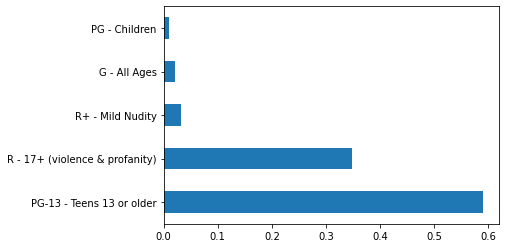

In [59]:
# plotting ratings
df.rating.value_counts(normalize = True).plot.barh()
plt.show()



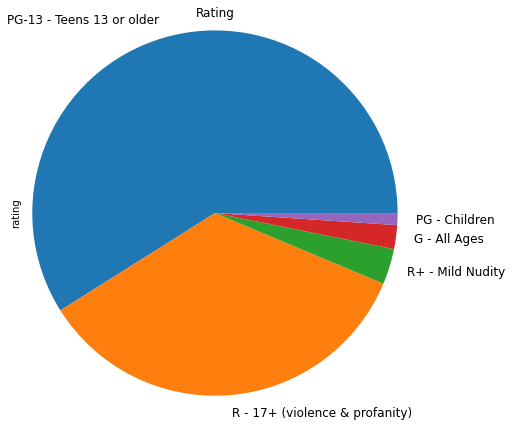

In [60]:
df.rating.value_counts(normalize = True).plot.pie(title = "Rating", radius = 1.2, figsize = (7, 7), fontsize = 12)
plt.show()

In [61]:
# getting proportions of source material
df.source.value_counts(normalize = True)

Manga           0.610526
Original        0.147368
Light novel     0.115789
Novel           0.052632
Visual novel    0.042105
Web manga       0.031579
Name: source, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

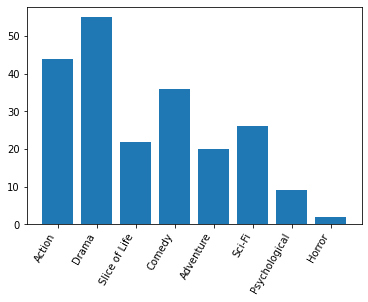

In [62]:
bar_x_axis = list(count_dict.keys())
bar_y_axis = list(count_dict.values())
plt.xticks(rotation=60, horizontalalignment='right', fontweight='light', fontsize='medium')
plt.bar(bar_x_axis, bar_y_axis)
plt.show


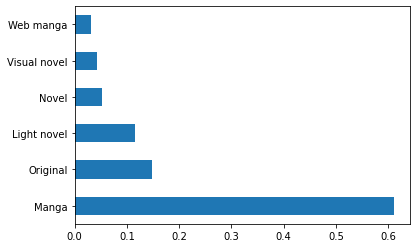

In [63]:
# plotting ratings
df.source.value_counts(normalize = True).plot.barh()
plt.show()

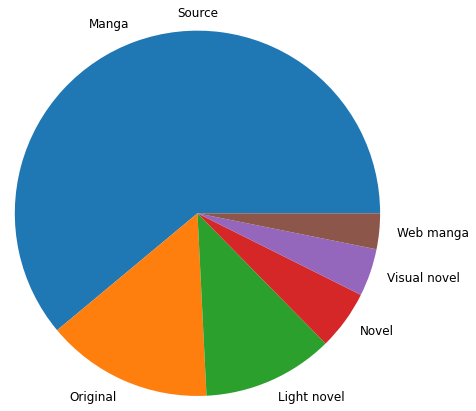

In [64]:
# plotting proportions of source material
df.source.value_counts(normalize = True).plot.pie(title = "Source", radius = 1.2, figsize = (7, 7), fontsize = 12)
plt.ylabel("")
plt.show()

In [65]:
# getting statistics about score
df.score.describe()

count    95.000000
mean      8.733474
std       0.169120
min       8.520000
25%       8.585000
50%       8.690000
75%       8.825000
max       9.150000
Name: score, dtype: float64

In [66]:
# getting statistics about time difference
df.time_difference.describe()


count      95.000000
mean      180.136842
std       396.887052
min         0.000000
25%         0.000000
50%        62.000000
75%       153.000000
max      3347.000000
Name: time_difference, dtype: float64

In [67]:
df.episode_count.describe()

count     95.000000
mean      21.210526
std       30.510861
min        1.000000
25%        1.000000
50%       13.000000
75%       25.000000
max      201.000000
Name: episode_count, dtype: float64

In [68]:
df.num_members.describe()

count    9.500000e+01
mean     7.195140e+05
std      6.723866e+05
min      3.804000e+04
25%      2.239490e+05
50%      4.090930e+05
75%      1.042660e+06
max      3.202989e+06
Name: num_members, dtype: float64

<AxesSubplot:xlabel='episode_count', ylabel='score'>

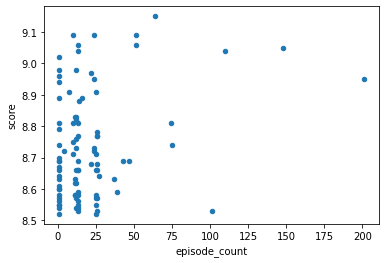

In [69]:
# generating scatter plot between episode count and score
df.plot.scatter(x = "episode_count", y = "score")

<AxesSubplot:xlabel='time_difference', ylabel='score'>

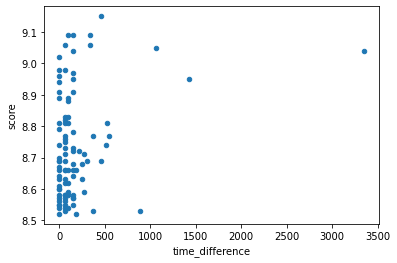

In [70]:
df.plot.scatter(x = "time_difference", y = "score")

<AxesSubplot:xlabel='num_members', ylabel='score'>

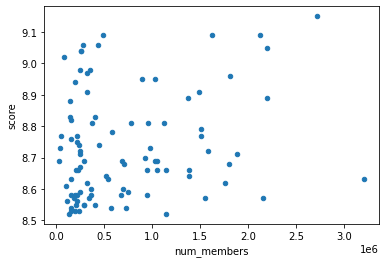

In [71]:
df.plot.scatter(x = "num_members", y = "score")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='score', ylabel='rating'>

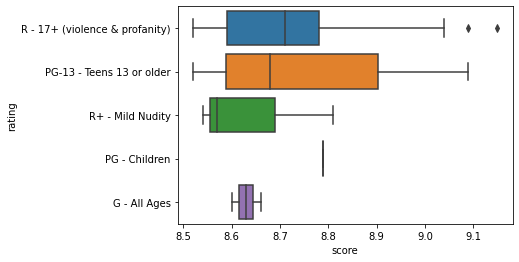

In [72]:
# generating boxplot between score and rating
sea.boxplot(df.score, df.rating)

In [73]:
# setting up correlation matrix
df[['episode_count', 'score', 'num_members', 'time_difference']].corr()

,episode_count,score,num_members,time_difference
episode_count,1.000000,0.293131,0.192618,0.766370
score,0.293131,1.000000,0.218584,0.280245
num_members,0.192618,0.218584,1.000000,0.052019
time_difference,0.766370,0.280245,0.052019,1.000000


<AxesSubplot:>

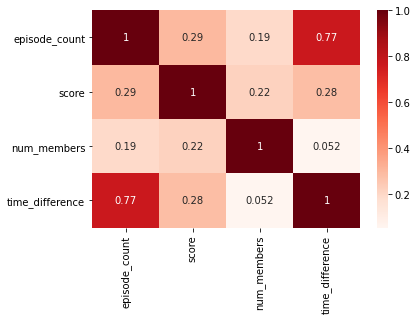

In [74]:
# generating heatmap from correlation matrix
sea.heatmap(df[['episode_count', 'score', 'num_members', 'time_difference']].corr(), annot = True, cmap = 'Reds')